<a href="https://colab.research.google.com/github/mnsv73/PM2.5-Prediction/blob/master/station1001regressionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains various models used to predict PM2.5 only on basis of the meteorlogical variables given for a particular day. No time series approach has been used. I extensively worked on ANN model. It predicted AQI Index with accuracy of about 60%.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.models import model_from_json
import random
import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
#tf.disable_v2_behavior()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.metrics import mean_squared_error
from math import sqrt

Using TensorFlow backend.


### Data Preprocessing

In [0]:
#loading data
data = pd.read_excel('/content/drive/My Drive/AQI Prediction/AQI Project/data2/station1001_1.xlsx')
dat1 = data.drop(['time'], axis=1)
z = dat1.isnull().any(axis=1)
print(dat1.head())

   PM25_Concentration  O3_Concentration  ...  wind_direction  weather
0                 138              50.8  ...            13.0      0.0
1                 124              51.1  ...            13.0      0.0
2                 127              27.2  ...            13.0      0.0
3                 129               9.7  ...            13.0      0.0
4                 119               2.0  ...             1.0      0.0

[5 rows x 8 columns]


In [0]:
#Seperating NA values
nandat = pd.DataFrame(columns = ['PM25_Concentration','O3_Concentration','temperature', 'pressure', 'humidity', 'wind_speed', 'wind_direction', 'weather'])
notnandat = pd.DataFrame(columns = ['PM25_Concentration','O3_Concentration','temperature', 'pressure', 'humidity', 'wind_speed', 'wind_direction', 'weather'])
for i in range(len(dat1)):
  if z[i]==True:
      nandat = nandat.append(dat1.iloc[i], ignore_index=True)
  elif z[i]==False:
    notnandat = notnandat.append(dat1.iloc[i], ignore_index=True)

In [0]:
#Loading the autoencoder model for data completion
json_file = open('/content/drive/My Drive/AQI Prediction/AQI Project/data2/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/My Drive/AQI Prediction/AQI Project/data2/station1enc.h5")

In [0]:
#Seperating the NA variables with PM2.5 values
x_inputnan = nandat.drop(['PM25_Concentration'], axis=1)
x_notnan1 = notnandat.drop(['PM25_Concentration'], axis=1)
y_nan = pd.DataFrame(nandat, columns = ['PM25_Concentration'])
y_notnan = pd.DataFrame(notnandat, columns = ['PM25_Concentration'])

#Normalising the variables used for prediction
min_max_scaler = preprocessing.MinMaxScaler()
x_nan = min_max_scaler.fit_transform(x_inputnan)
x_notnan = min_max_scaler.fit_transform(x_notnan1)

#Filling the NA values with -1
for i in range(len(x_nan)):
  for j in range (0,7):
    if math.isnan(x_nan[i][j]):
        x_nan[i][j] = -1


In [0]:
#Predicitng the missing values to complete the data and filling them up correspondingly
x_predicted = loaded_model.predict(x_nan)
for i in range(len(x_nan)):
    for j in range (0, 7):
        if x_nan[i][j] == -1.0 :
            x_nan[i][j] = x_predicted[i][j]

In [0]:
#Combining the NA and not NA values to form complete dataset
X_scaled = np.concatenate((x_nan, x_notnan), axis=0)
y_scaled = np.concatenate((y_nan, y_notnan), axis=0)

#### Applying Principal Component Analysis (PCA)
The variables were not related to each other. Applying PCA makes the data align towards dimensions of maximum correlation

In [0]:
def find_eigen_decomposition(matrix):
    '''
    use numpy to find the eigen decomposition of the matrix
    returns eigenValues and the eigenVectors
    '''
    eigval, eigvec = np.linalg.eig(matrix)
    return eigval, eigvec.T

In [0]:
def center(X):
    '''
    function to center the data around the mean
    modify the return value to return the modified matrix
    '''
    X = X - np.mean(X, axis=0)
    return X

In [0]:
def find_covariance_matrix(X):
    trans = X.transpose()
    new = (trans.dot(X))/len(X)
    return new 

In [0]:
def apply_pca(data):
    data_centered = center(data)
    cov = find_covariance_matrix(data_centered)
    eVals, eVecs = find_eigen_decomposition(cov)
    key = np.argsort(eVals)[::-1]
    sval = np.sort(eVals)[::-1]
    svec1 = np.zeros((len(eVals), len(eVals)))
    for i in range(len(eVecs)):
      svec1[i] = eVecs[key[i]]
    svec = np.transpose(svec1)
    zstar = data_centered.dot(svec)
    return zstar

In [0]:
x_new = apply_pca(X_scaled)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_new, y_scaled, test_size=0.2, random_state=42)

## Models

### 1. Feed-forward ANN

In [0]:
import keras.backend as K
#Building a regression model for AQI Prediction
model = Sequential()
model.add(Dense(units = 64, kernel_initializer = "normal", activation = "relu", input_dim = 7,activity_regularizer = regularizers.l2(0.01)))
model.add(Dropout(rate = 0.05))
model.add(Dense(units = 128, kernel_initializer = "normal", activation = "relu"))
model.add(Dropout(rate = 0.05))
model.add(Dense(units = 256, kernel_initializer = "normal", activation = "relu"))
model.add(Dense(units = 1, kernel_initializer = "normal", activation = "linear"))

In [0]:
#training the model
model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics=['mean_absolute_error'])
history = model.fit(X_train, y_train, batch_size = 8, epochs = 250, validation_split = 0.1)

Train on 5319 samples, validate on 591 samples
Epoch 1/250
5319/5319 [==============================] - 1s 274us/step - loss: 57.1627 - mean_absolute_error: 57.1286 - val_loss: 51.9164 - val_mean_absolute_error: 51.8831
Epoch 2/250
5319/5319 [==============================] - 1s 216us/step - loss: 52.4723 - mean_absolute_error: 52.4487 - val_loss: 47.8884 - val_mean_absolute_error: 47.8717
Epoch 3/250
5319/5319 [==============================] - 1s 209us/step - loss: 49.7304 - mean_absolute_error: 49.7173 - val_loss: 46.9893 - val_mean_absolute_error: 46.9770
Epoch 4/250
5319/5319 [==============================] - 1s 217us/step - loss: 49.2721 - mean_absolute_error: 49.2613 - val_loss: 46.1544 - val_mean_absolute_error: 46.1442
Epoch 5/250
5319/5319 [==============================] - 1s 217us/step - loss: 48.7422 - mean_absolute_error: 48.7324 - val_loss: 46.2856 - val_mean_absolute_error: 46.2759
Epoch 6/250
5319/5319 [==============================] - 1s 222us/step - loss: 48.6883 -

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


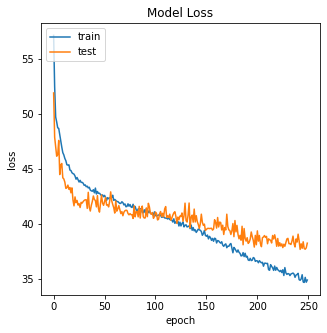

In [0]:
#Plotting model's losses
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
nn_pred = model.predict(X_test)
nn_scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', nn_scores[0])
print('Test accuracy:', nn_scores[1])
print(np.sqrt(mean_squared_error(y_test,nn_pred)))

1478/1478 [==============================] - 0s 23us/step
Test loss: 38.12924834420458
Test accuracy: 37.94878005981445
57.18770359243361


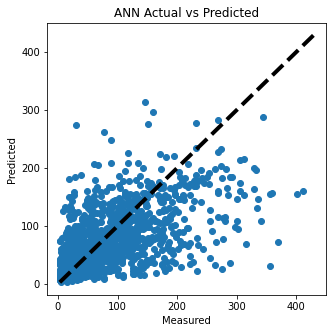

In [0]:
#Scatter plot Predicted v/s Actual Value
fig, ax = plt.subplots()
ax.scatter(y_test, nn_pred)
ax.plot([y_scaled.min(), y_scaled.max()], [y_scaled.min(), y_scaled.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('ANN Actual vs Predicted')
plt.show()

In [0]:
#Saving and comparing actual vs predicted AQI Index and PM2.5
df = pd.DataFrame(data=np.column_stack((y_test,nn_pred)),columns=['a','p'])
print(df)
df.to_excel("/content/drive/My Drive/AQI Prediction/AQI Project/data2/ann.xlsx")

          a          p
0      94.0  85.000282
1      20.0  58.600693
2     109.0  46.419258
3       5.0  23.223616
4     125.0  62.626385
...     ...        ...
1473   87.0  58.232368
1474  142.0  77.712952
1475    3.0  17.447020
1476  108.0  64.822647
1477   14.0  38.795471

[1478 rows x 2 columns]


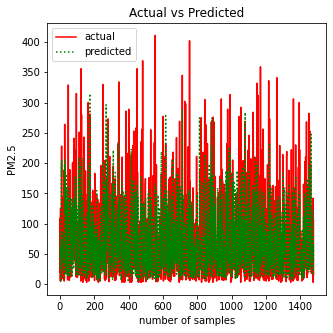

In [0]:
#Line plot of actual vs predicted
plt.plot(df.a, 'r')
plt.plot(df.p, 'g:')
plt.title('Actual vs Predicted')
plt.ylabel('PM2.5')
plt.xlabel('number of samples')
plt.legend(['actual', 'predicted'], loc='upper left')

In [0]:
#adf test on input data
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(df['p'])

#test static is less than critical value. series is stationary

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Results of Dickey-Fuller Test:
Test Statistic                  -37.804054
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1477.000000
Critical Value (1%)              -3.434785
Critical Value (5%)              -2.863499
Critical Value (10%)             -2.567813
dtype: float64


In [0]:
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test(df['p'])

#test static is greater than critical value. series is not stationary

Results of KPSS Test:
Test Statistic            0.084083
p-value                   0.100000
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Results of KPSS Test:
Test Statistic              NaN
p-value                     NaN
Lags Used                24.000
Critical Value (10%)      0.347
Critical Value (5%)       0.463
Critical Value (2.5%)     0.574
Critical Value (1%)       0.739
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


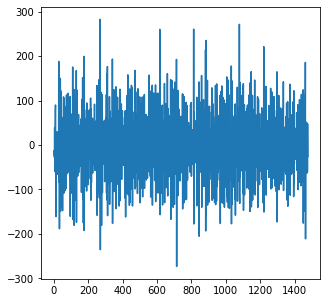

In [0]:
'''series is difference stationary.
can be made stationary by differencing'''
df['diff'] = df['p'] - df['p'].shift(1)
df['diff'].dropna().plot()
kpss_test(df['diff'])

### 2.Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Create Random Forrest Regressor object
regr_rf = RandomForestRegressor(n_estimators=200, random_state=1234)

In [0]:
# Train the model using the training sets
regr_rf.fit(X_train, y_train)

# Score the model
decision_forest_score = regr_rf.score(X_test, y_test)
decision_forest_score

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.3753059079570318

In [0]:
# Make predictions using the testing set
regr_rf_pred = regr_rf.predict(X_test)
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, regr_rf_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, regr_rf_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, regr_rf_pred))

Root mean squared error: 55.81
Mean absolute error: 39.89
R-squared: 0.38


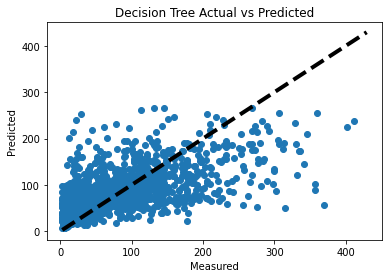

In [0]:
#Scatter plot Predicted v/s Actual Value
fig, ax = plt.subplots()
ax.scatter(y_test, regr_rf_pred)
ax.plot([y_scaled.min(), y_scaled.max()], [y_scaled.min(), y_scaled.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Decision Tree Actual vs Predicted')
plt.show()

###3.Decision Tree Regressor

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create Decision Tree Regressor object
tree_1 = DecisionTreeRegressor()

tree_2 = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=200, learning_rate=.1)
# Train the model using the training sets
tree_1.fit(X_train, y_train)
tree_2.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

In [0]:
# Score the decision tree model
tree_1.score(X_test, y_test)

-0.24854423018269922

In [0]:
# Score the boosted decision tree model
boosted_tree_score = tree_2.score(X_test, y_test)
boosted_tree_score

0.323301878072344

In [0]:
# Make predictions using the testing set
tree_1_pred = tree_1.predict(X_test)
tree_2_pred = tree_2.predict(X_test)

# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, tree_2_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, tree_2_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, tree_2_pred))

Root mean squared error: 58.09
Mean absolute error: 37.11
R-squared: 0.32


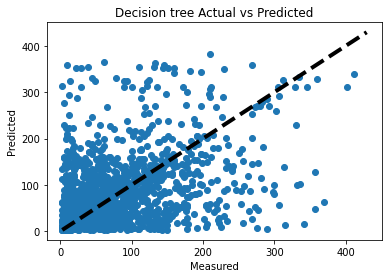

In [0]:
#Scatter plot Predicted v/s Actual Value
fig, ax = plt.subplots()
ax.scatter(y_test, tree_1_pred)
ax.plot([y_scaled.min(), y_scaled.max()], [y_scaled.min(), y_scaled.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Decision tree Actual vs Predicted')
plt.show()

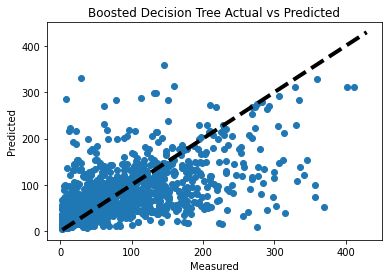

In [0]:
#Scatter plot Predicted v/s Actual Value
fig, ax = plt.subplots()
ax.scatter(y_test, tree_2_pred)
ax.plot([y_scaled.min(), y_scaled.max()], [y_scaled.min(), y_scaled.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Boosted Decision Tree Actual vs Predicted')
plt.show()

### 4.XGB Regressor

In [0]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=x_new,label=y_scaled)
xboost = xgb.XGBRegressor()
xboost.fit(X_train,y_train)
xgb_pred = xboost.predict(X_test)

[06:00:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("RMSE: %f" % (rmse))

RMSE: 60.630899


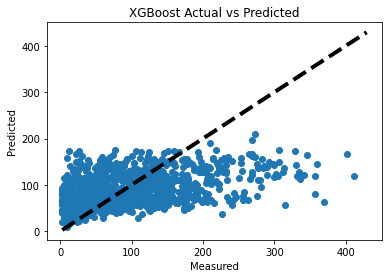

In [0]:
#Scatter plot Predicted v/s Actual Value
fig, ax = plt.subplots()
ax.scatter(y_test, xgb_pred)
ax.plot([y_scaled.min(), y_scaled.max()], [y_scaled.min(), y_scaled.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('XGBoost Actual vs Predicted')
plt.show()

In [0]:
xgb_score = xboost.score
print(xgb_score)

<bound method RegressorMixin.score of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)>


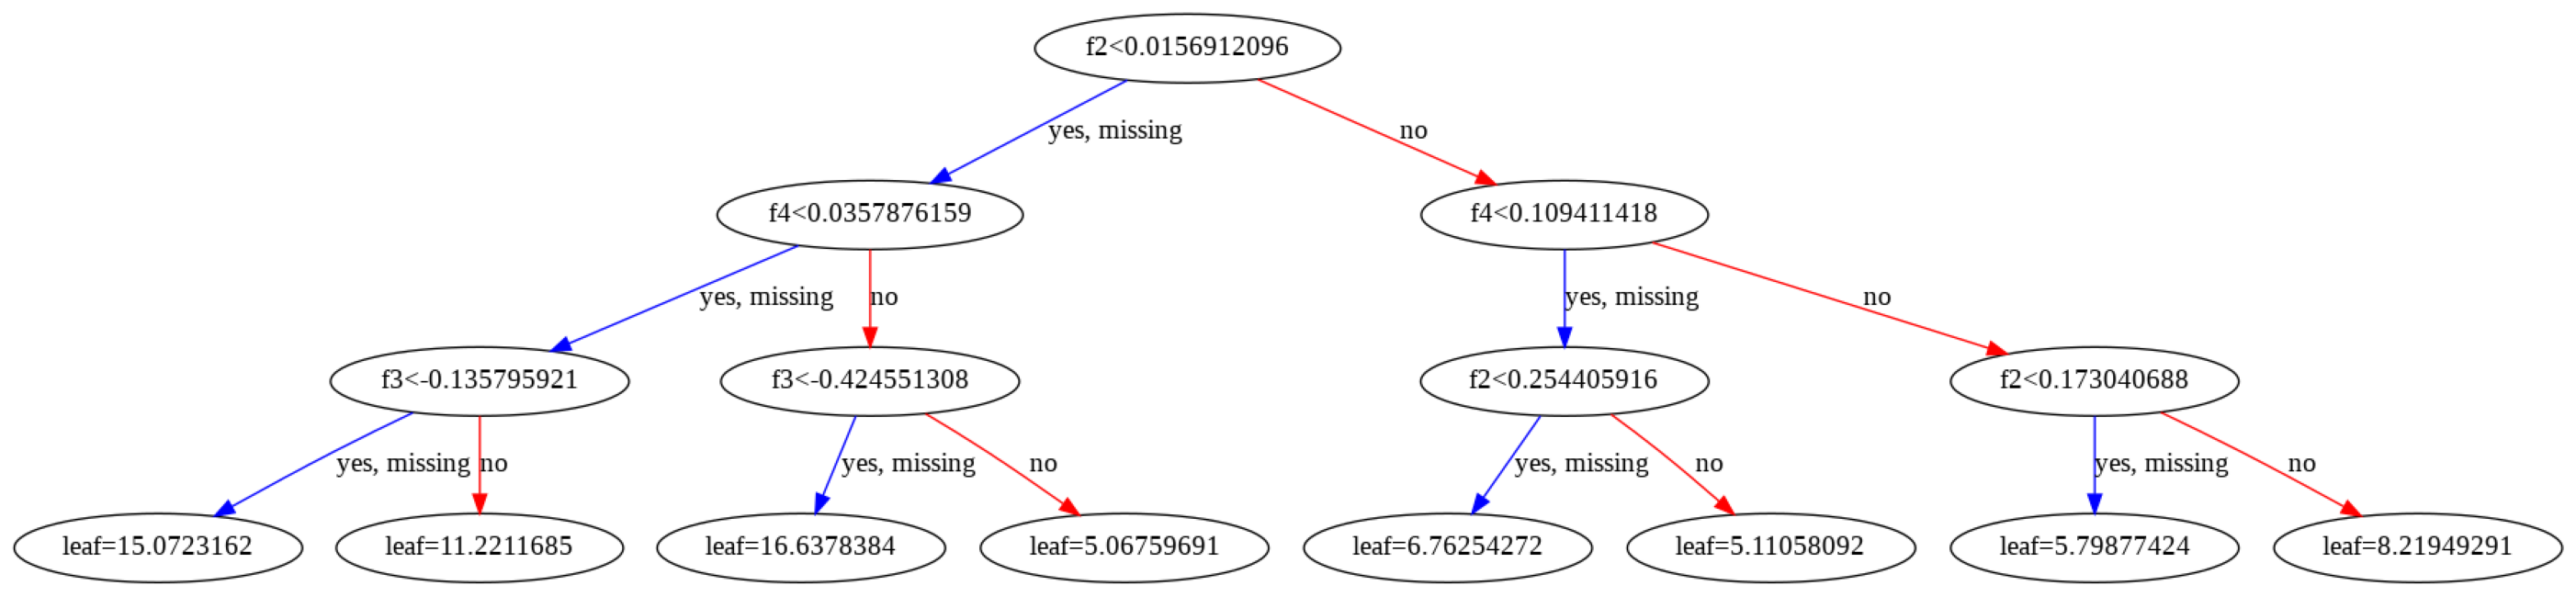

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50, 50]
xgb.plot_tree(xboost,num_trees=0)
plt.show()

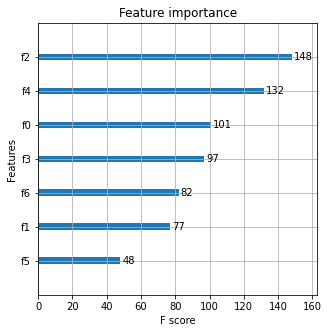

In [0]:
xgb.plot_importance(xboost)
#plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [0]:
#Comparison among above models
print("Scores:")
print("Neural network regression score: ", nn_scores[0])
print("Decision forest score: ", decision_forest_score)
print("Boosted decision tree score: ", boosted_tree_score)
print("XGBoost score:", xgb_score)
print("\n")
print("RMSE:")
print("Neural network RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, nn_pred)))
print("Decision forest RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, regr_rf_pred)))
print("Boosted decision tree RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, tree_2_pred)))
print("XGBoost RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, xgb_pred)))

Scores:
Neural network regression score:  38.12924834420458
Decision forest score:  0.3753059079570318
Boosted decision tree score:  0.323301878072344
XGBoost score: <bound method RegressorMixin.score of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)>


RMSE:
Neural network RMSE: 57.19
Decision forest RMSE: 55.81
Boosted decision tree RMSE: 58.09
XGBoost RMSE: 60.63
